# 0. Importações

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings("ignore")

# 1. Carregar os dados

In [2]:
try:
    df = pd.read_csv("/content/dados_preco.csv")
    print("✅ Arquivo carregado com sucesso a partir de /content/dados_preco.csv")
except Exception as e:
    print("Erro ao carregar o arquivo local. Tentando a partir da URL...")
    df = pd.read_csv("https://raw.githubusercontent.com/manipulaeHealth/desafio-machine-learning/main/dados_preco.csv")

✅ Arquivo carregado com sucesso a partir de /content/dados_preco.csv


In [3]:
df.sample(7)

,descricao,criado,qtdInsumos,calculado,correto
5377,60 CAP | AMIDO 0.500MG,2020-07-18 14:45:16,1,30.0028,44.0
1644,60 CAP | SERENOA REPENS 160MG; NUTRICOLIN 10...,2020-07-31 21:30:10,8,236.4047,221.1
5327,60 CAP | CACTI-NEA 500MG; CAVALINHA 500MG; C...,2020-07-18 17:31:08,4,385.7551,374.3
3899,60 CAP | CURCUMA LONGA 150MG; GINKGO BILOBA E...,2020-07-24 13:41:14,3,75.6655,67.0
5589,90 CAP | PHOLIAMAGRA 250MG,2020-07-17 16:19:10,1,97.2876,93.0
6891,30 CAP | VITAMINA D LIQ CAP 10000UI; VITAMINA...,2020-07-10 17:34:14,2,40.8930,40.0
526,180 CAP | MAGNESIO DIMALATO 400MG,2020-08-04 20:43:08,1,123.8733,113.6


# 2. Exploração Inicial

In [4]:
print("\n📌 Informações Gerais:")
print(df.info())
print("\n📌 Estatísticas Descritivas:")
print(df.describe())
print("\n📌 Valores Nulos:")
print(df.isnull().sum())


📌 Informações Gerais:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7121 entries, 0 to 7120
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   descricao   7121 non-null   object 
 1   criado      7121 non-null   object 
 2   qtdInsumos  7121 non-null   int64  
 3   calculado   7121 non-null   float64
 4   correto     7121 non-null   float64
dtypes: float64(2), int64(1), object(2)
memory usage: 278.3+ KB
None

📌 Estatísticas Descritivas:
        qtdInsumos     calculado       correto
count  7121.000000   7121.000000   7121.000000
mean      3.281842    137.089552    135.891798
std       3.194301    191.266516    189.806974
min       1.000000     30.000100     33.000000
25%       1.000000     49.786100     49.500000
50%       2.000000     87.350300     83.100000
75%       4.000000    165.167000    161.200000
max      26.000000  10364.992500  10356.000000

📌 Valores Nulos:
descricao     0
criado        0
qtdInsumos   

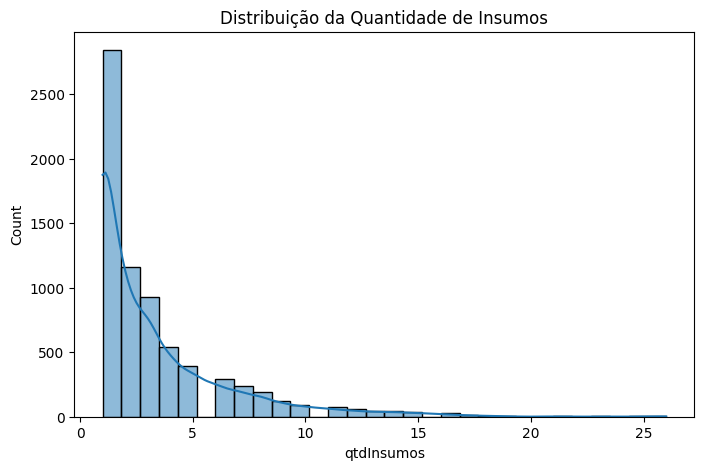

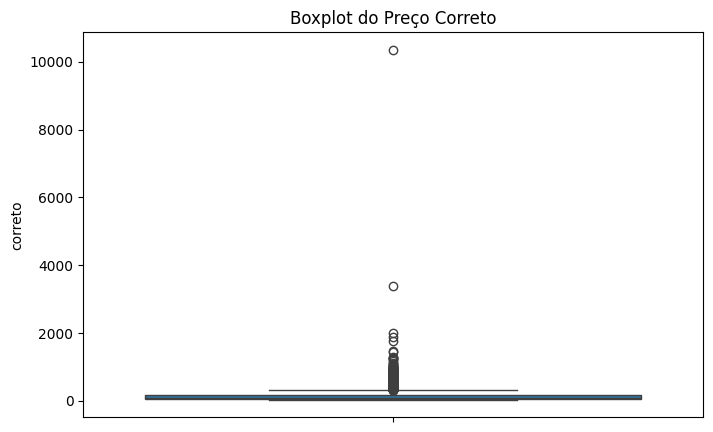

In [5]:
# Visualizações iniciais
plt.figure(figsize=(8,5))
sns.histplot(df['qtdInsumos'], bins=30, kde=True)
plt.title("Distribuição da Quantidade de Insumos")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(y=df['correto'])
plt.title("Boxplot do Preço Correto")
plt.show()

# 3. Pré-processamento dos Dados

In [6]:
# Converter a coluna 'criado' para datetime e ordenar cronologicamente (importante se houver tendência temporal)
df['criado'] = pd.to_datetime(df['criado'])
df = df.sort_values(by="criado")  # Garante que os dados estejam em ordem temporal

In [7]:
# Extração de features temporais adicionais: ano, mês, dia, trimestre e dia da semana
df['ano'] = df['criado'].dt.year
df['mes'] = df['criado'].dt.month
df['dia'] = df['criado'].dt.day
df['trimestre'] = df['criado'].dt.quarter
df['dia_semana'] = df['criado'].dt.dayofweek

In [8]:
# Remoção de outliers com base no IQR
def remove_outliers(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lim_inf = q1 - 1.5 * iqr
    lim_sup = q3 + 1.5 * iqr
    return data[(data[column] >= lim_inf) & (data[column] <= lim_sup)]

df = remove_outliers(df, 'qtdInsumos')
df = remove_outliers(df, 'calculado')
df = remove_outliers(df, 'correto')

In [9]:
# Remover duplicatas
df = df.drop_duplicates()

# 4. Engenharia de Features

In [10]:
# Transformador para a coluna 'descricao'
class DescricaoTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['num_insumos'] = X['descricao'].apply(lambda x: len(x.split(';')) if isinstance(x, str) else 0)

        # Extrair nomes dos insumos
        X['insumos'] = X['descricao'].apply(lambda x: [
            re.findall(r'([a-zA-Z\s]+)\s\d+', i)[0].strip() if re.findall(r'([a-zA-Z\s]+)\s\d+', i)
            else ''
            for i in x.split(';') if i.strip() != ""
        ] if isinstance(x, str) else [])

        # Extrair quantidades dos insumos
        X['quantidades'] = X['descricao'].apply(lambda x: [
            int(re.findall(r'\d+', i)[0]) if re.findall(r'\d+', i)
            else 0
            for i in x.split(';') if i.strip() != ""
        ] if isinstance(x, str) else [])

        return X

In [11]:
descricao_transformer = DescricaoTransformer()
df = descricao_transformer.transform(df)

In [12]:
# Features adicionais baseadas na descrição
df['soma_quantidades'] = df['quantidades'].apply(sum)
df['media_quantidades'] = df['quantidades'].apply(lambda x: sum(x)/len(x) if len(x) > 0 else 0)
df['num_insumos_unicos'] = df['insumos'].apply(lambda x: len(set(x)))

In [13]:
# Codificação da feature 'complexidade' baseada em 'qtdInsumos'
df['complexidade'] = np.where(df['qtdInsumos'] <= 3, 'baixa',
                              np.where(df['qtdInsumos'] <= 6, 'media', 'alta'))
label_encoder = LabelEncoder()
df['complexidade_encoded'] = label_encoder.fit_transform(df['complexidade'])

In [14]:
# Criar features derivadas dos preços
df['calc_qtd_ratio'] = df['calculado'] / df['qtdInsumos']
df['calc_qtd_mult'] = df['calculado'] * df['qtdInsumos']

In [15]:
# === One-Hot Encoding para Insumos com agrupamento de insumos pouco frequentes ===
# Calcular a frequência de cada insumo
all_insumos_flat = [insumo for sublist in df['insumos'] for insumo in sublist if insumo != '']
freq = Counter(all_insumos_flat)

In [16]:
# Definir um limiar para insumos frequentes (por exemplo, 50 ocorrências)
threshold = 50
frequent_insumos = [insumo for insumo, count in freq.items() if count >= threshold]

In [17]:
# Criação de colunas para insumos frequentes
for insumo in frequent_insumos:
    df[f'insumo_{insumo}'] = df['insumos'].apply(lambda x: 1 if insumo in x else 0)

In [18]:
# Criação de coluna para agrupar insumos pouco frequentes como "outros"
df['insumo_outros'] = df['insumos'].apply(lambda x: 1 if any(insumo not in frequent_insumos and insumo != '' for insumo in x) else 0)


# 5. Separação dos Dados para Treinamento

In [19]:
# A divisão é feita cronologicamente para preservar a estrutura temporal:
# Treino: registros mais antigos (primeiros 5121)
# Teste: registros mais recentes (últimos 2000)
train_df = df.iloc[:5121]
test_df = df.iloc[5121:]

In [20]:
# Seleção de features
# Incluímos as features temporais adicionais e as de one-hot encoding dos insumos frequentes e "outros"
features = [
    'calculado', 'complexidade_encoded', 'calc_qtd_ratio', 'calc_qtd_mult',
    'ano', 'mes', 'dia', 'trimestre', 'dia_semana', 'soma_quantidades', 'media_quantidades', 'num_insumos_unicos'
]

In [21]:
# Adiciona as features de insumos (frequentes + outros)
for insumo in frequent_insumos:
    features.append(f'insumo_{insumo}')
features.append('insumo_outros')

In [22]:
X_train = train_df[features]
X_test = test_df[features]
y_train = train_df['correto']
y_test = test_df['correto']

In [23]:
# Padronização
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 6. Treinamento do Modelo

In [24]:
# Expansão dos ranges de hiperparâmetros para melhor ajuste
models = {
    'XGBRegressor': XGBRegressor(random_state=42, verbosity=0),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42)
}

param_grid = {
    'XGBRegressor': {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7]
    },
    'RandomForestRegressor': {
        'n_estimators': [50, 100, 200, 300],
        'max_depth': [3, 5, 7]
    },
    'GradientBoostingRegressor': {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7]
    }
}

In [25]:
best_model = None
best_rmse = float('inf')
best_model_name = None

In [26]:
for model_name, model in models.items():
    print(f"\n🔍 Tunando {model_name}...")
    grid_search = GridSearchCV(model, param_grid[model_name], cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"✅ RMSE do {model_name}: {rmse:.4f}")
    if rmse < best_rmse:
        best_rmse = rmse
        best_model = grid_search.best_estimator_
        best_model_name = model_name


🔍 Tunando XGBRegressor...
✅ RMSE do XGBRegressor: 9.6557

🔍 Tunando RandomForestRegressor...
✅ RMSE do RandomForestRegressor: 10.1629

🔍 Tunando GradientBoostingRegressor...
✅ RMSE do GradientBoostingRegressor: 9.6370


In [27]:
print(f"\n🏆 Melhor modelo: {best_model_name} com RMSE: {best_rmse:.4f}")


🏆 Melhor modelo: GradientBoostingRegressor com RMSE: 9.6370


# 7. Avaliação do Modelo

In [28]:
y_pred = best_model.predict(X_test)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"\n✅ RMSE do Melhor Modelo na Avaliação Final: {rmse_final:.4f}")


✅ RMSE do Melhor Modelo na Avaliação Final: 9.6370


In [29]:
# Análise de Resíduos
residuos = y_test - y_pred

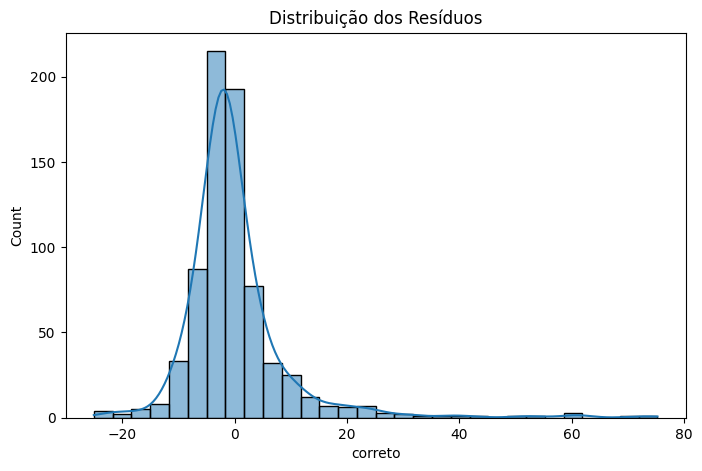

In [30]:
plt.figure(figsize=(8,5))
sns.histplot(residuos, bins=30, kde=True)
plt.title("Distribuição dos Resíduos")
plt.show()

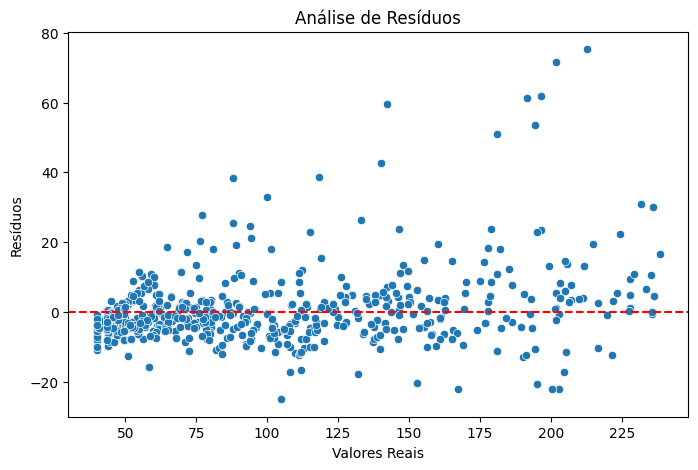

In [31]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Valores Reais")
plt.ylabel("Resíduos")
plt.title("Análise de Resíduos")
plt.show()

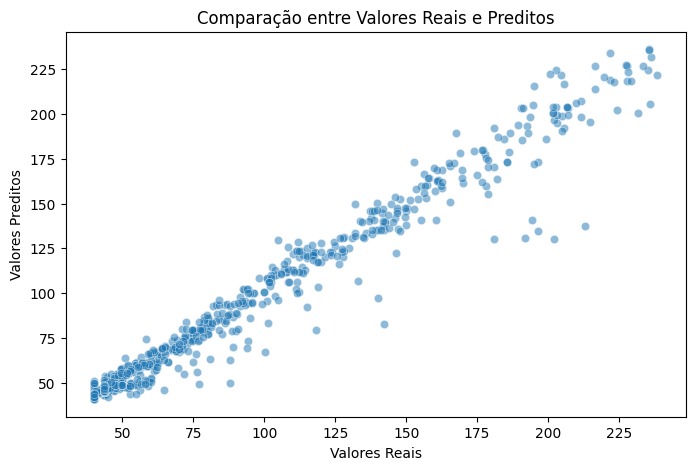

In [32]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Preditos")
plt.title("Comparação entre Valores Reais e Preditos")
plt.show()

# 8. Interpretabilidade: Análise da Importância das Features


📊 Importância das Features (em ordem decrescente):
calculado: 0.9844
soma_quantidades: 0.0033
calc_qtd_mult: 0.0030
media_quantidades: 0.0029
insumo_ACIDO ALFA LIPOICO: 0.0026
calc_qtd_ratio: 0.0011
insumo_ACIDO FOLICO: 0.0004
insumo_RHAMNOSUS LACTOBACILLUS: 0.0003
dia_semana: 0.0002
dia: 0.0002
insumo_MAGNESIO DIMALATO: 0.0002
insumo_MAGNESIO QUELADO: 0.0001
insumo_outros: 0.0001
insumo_ZINCO QUELADO: 0.0001
insumo_PARACASEI LACTOBACILLUS: 0.0001
insumo_PIPERINA: 0.0001
insumo_VITAMINA A: 0.0001
insumo_VITAMINA D: 0.0001
insumo_VITAMINA D LIQ CAP ATE: 0.0001
insumo_PASSIFLORA: 0.0000
insumo_BULGARICUS LACTOBACILLUS: 0.0000
insumo_CURCUMA LONGA: 0.0000
num_insumos_unicos: 0.0000
insumo_VITAMINA C: 0.0000
insumo_PLANTARUM LACTOBACILLUS: 0.0000
insumo_VITAMINA D LIQ CAP ACIMA: 0.0000
insumo_METILFOLATO: 0.0000
insumo_RESVERATROL: 0.0000
insumo_CASEI LACTOBACILLUS: 0.0000
insumo_BIFIDOBACTERIUM INFANTIS: 0.0000
insumo_BIFIDOBACTERIUM LACTIS: 0.0000
insumo_VITAMINA A OLEOSA ORAL: 0.0000
c

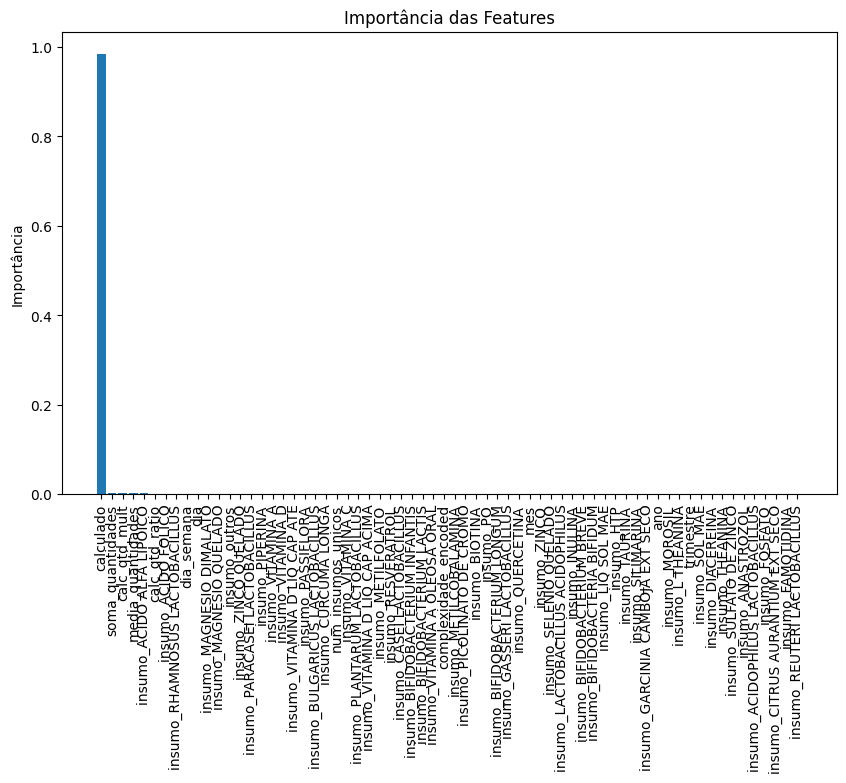

In [33]:
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feature_names = np.array(features)
    sorted_idx = np.argsort(importances)[::-1]

    print("\n📊 Importância das Features (em ordem decrescente):")
    for idx in sorted_idx:
        print(f"{feature_names[idx]}: {importances[idx]:.4f}")

    plt.figure(figsize=(10,6))
    plt.bar(feature_names[sorted_idx], importances[sorted_idx])
    plt.xticks(rotation=90)
    plt.title("Importância das Features")
    plt.ylabel("Importância")
    plt.show()
else:
    print("O modelo selecionado não possui atributo 'feature_importances_'.")

# 9. Exportação dos Dados para Power BI

In [34]:
df[['descricao', 'qtdInsumos', 'calculado', 'correto', 'complexidade',
    'ano', 'mes', 'dia', 'trimestre', 'dia_semana',
    'soma_quantidades', 'media_quantidades', 'num_insumos_unicos',
    'calc_qtd_ratio', 'calc_qtd_mult', 'insumo_outros'
]].to_csv("dados_tratados.csv", index=False)

print("\n✅ Modelagem concluída e dados exportados para Power BI!")


✅ Modelagem concluída e dados exportados para Power BI!


In [35]:
# Resumo final dos testes
resultado_teste = {
    "Melhor Modelo": best_model_name,
    "RMSE Final": rmse_final
}

In [36]:
print("\nResumo dos Testes:")
print(resultado_teste)


Resumo dos Testes:
{'Melhor Modelo': 'GradientBoostingRegressor', 'RMSE Final': 9.637003856110416}
